---

## Objectives
1. Implement Random Forest Classifier
2. Implement Support Vector Machine
3. Implement K-Nearest Neighbors
4. Perform hyperparameter tuning
5. Compare algorithm performance

---


In [ ]:
# Import libraries and load features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import time
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
import os


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, cohen_kappa_score, confusion_matrix,
                           classification_report)
from sklearn.preprocessing import LabelEncoder

# Add src to path
sys.path.append('../../src')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Setup paths
PROCESSED_PATH = Path("../../data/processed")
MODELS_PATH = Path("../../results/models")
FIGURES_PATH = Path("../../results/figures/model_comparison")

# Create directories
MODELS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

print("Loading engineered features...")

X_train = np.load(PROCESSED_PATH / 'X_train_pca.npy')
X_test = np.load(PROCESSED_PATH / 'X_test_pca.npy')
y_train = np.load(PROCESSED_PATH / 'y_train_position.npy')
y_test = np.load(PROCESSED_PATH / 'y_test_position.npy')

# Load metadata
train_metadata = pd.read_csv(PROCESSED_PATH / 'train_metadata.csv')
test_metadata = pd.read_csv(PROCESSED_PATH / 'test_metadata.csv')

print(f"✓ Loaded training features: {X_train.shape}")
print(f"✓ Loaded test features: {X_test.shape}")
print(f"✓ Number of PCA components: {X_train.shape[1]}")

# Check class distribution
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for pos, count in zip(unique, counts):
    print(f"  {pos}: {count} ({count/len(y_train)*100:.1f}%)")

# Encode labels if needed (for consistency in metrics)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_names = label_encoder.classes_

print(f"\nClass mapping: {dict(zip(range(len(class_names)), class_names))}")

Loading engineered features...
✓ Loaded training features: (2061, 114)
✓ Loaded test features: (516, 114)
✓ Number of PCA components: 114

Class distribution in training set:
  Sitting: 1048 (50.8%)
  Standing: 972 (47.2%)
  Unknown: 41 (2.0%)

Class mapping: {0: 'Sitting', 1: 'Standing', 2: 'Unknown'}


In [ ]:
# Define models and hyperparameter search spaces
print("Defining machine learning models...")

# Define models
models = {
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}


param_grids = {
    'SVM': {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf'],
        'probability': [True]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}


scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

print("Models and hyperparameters defined:")
for model_name, params in param_grids.items():
    print(f"\n{model_name}:")
    for param, values in params.items():
        print(f"  {param}: {values}")

Defining machine learning models...
Models and hyperparameters defined:

SVM:
  C: [0.1, 1.0, 10.0]
  gamma: ['scale', 'auto', 0.001, 0.01]
  kernel: ['rbf']
  probability: [True]

KNN:
  n_neighbors: [3, 5, 7, 9]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan']

Random Forest:
  n_estimators: [50, 100, 200]
  max_depth: [None, 10, 20, 30]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]


In [ ]:
# Train models with cross-validation 
print("Starting model training with 5-fold cross-validation...")
print("This may take several minutes...\n")

# Initialize results storage
results = {}
best_models = {}
cv_results = {}

# Setup stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train each model
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train_encoded)
    
    # Store best model
    best_models[model_name] = grid_search.best_estimator_
    
    
    cv_scores = cross_validate(
        grid_search.best_estimator_,
        X_train,
        y_train_encoded,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    
    
    cv_results[model_name] = {
        'train_accuracy': np.mean(cv_scores['train_accuracy']),
        'val_accuracy': np.mean(cv_scores['test_accuracy']),
        'val_accuracy_std': np.std(cv_scores['test_accuracy']),
        'val_precision': np.mean(cv_scores['test_precision']),
        'val_recall': np.mean(cv_scores['test_recall']),
        'val_f1': np.mean(cv_scores['test_f1']),
        'best_params': grid_search.best_params_,
        'training_time': time.time() - start_time
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"Training time: {cv_results[model_name]['training_time']:.2f} seconds")
    
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    
    results[model_name] = {
        'accuracy': accuracy_score(y_test_encoded, y_pred),
        'precision': precision_score(y_test_encoded, y_pred, average='weighted'),
        'recall': recall_score(y_test_encoded, y_pred, average='weighted'),
        'f1': f1_score(y_test_encoded, y_pred, average='weighted'),
        'cohen_kappa': cohen_kappa_score(y_test_encoded, y_pred),
        'confusion_matrix': confusion_matrix(y_test_encoded, y_pred),
        'predictions': y_pred
    }
    
    print(f"Test accuracy: {results[model_name]['accuracy']:.4f}")

print("\n" + "="*50)
print("All models trained successfully!")
print("="*50)

Starting model training with 5-fold cross-validation...
This may take several minutes...


Training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
Best CV accuracy: 0.9981
Training time: 5.07 seconds
Test accuracy: 1.0000

Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/gaurav/.conda/envs/posture_analysis/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/gaurav/.conda/envs/posture_analysis/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t


Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV accuracy: 0.9971
Training time: 0.48 seconds
Test accuracy: 1.0000

Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV accuracy: 0.9704
Training time: 41.68 seconds
Test accuracy: 0.9767

All models trained successfully!


In [ ]:
# model performance
print("Model Performance Comparison")
print("="*80)

# comparison dataframe
comparison_data = []
for model_name in models.keys():
    comparison_data.append({
        'Algorithm': model_name,
        'CV Accuracy': f"{cv_results[model_name]['val_accuracy']:.4f} ± {cv_results[model_name]['val_accuracy_std']:.4f}",
        'Test Accuracy': f"{results[model_name]['accuracy']:.4f}",
        'Precision': f"{results[model_name]['precision']:.4f}",
        'Recall': f"{results[model_name]['recall']:.4f}",
        'F1-Score': f"{results[model_name]['f1']:.4f}",
        'Cohen\'s Kappa': f"{results[model_name]['cohen_kappa']:.4f}",
        'Training Time (s)': f"{cv_results[model_name]['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
print(f"\n✓ Best performing model: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

# results for each model
print("\n" + "="*80)
print("Detailed Results by Model")
print("="*80)

for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"  Best parameters: {cv_results[model_name]['best_params']}")
    print(f"  Cross-validation scores:")
    print(f"    - Accuracy: {cv_results[model_name]['val_accuracy']:.4f} ± {cv_results[model_name]['val_accuracy_std']:.4f}")
    print(f"    - Precision: {cv_results[model_name]['val_precision']:.4f}")
    print(f"    - Recall: {cv_results[model_name]['val_recall']:.4f}")
    print(f"    - F1-Score: {cv_results[model_name]['val_f1']:.4f}")

# Save results table
df_comparison.to_csv(MODELS_PATH / 'model_comparison_results.csv', index=False)
print(f"\n✓ Results saved to: {MODELS_PATH / 'model_comparison_results.csv'}")

Model Performance Comparison
    Algorithm     CV Accuracy Test Accuracy Precision Recall F1-Score Cohen's Kappa Training Time (s)
          SVM 0.9981 ± 0.0018        1.0000    1.0000 1.0000   1.0000        1.0000              5.07
          KNN 0.9971 ± 0.0028        1.0000    1.0000 1.0000   1.0000        1.0000              0.48
Random Forest 0.9704 ± 0.0064        0.9767    0.9770 0.9767   0.9752        0.9547             41.68

✓ Best performing model: SVM (Accuracy: 1.0000)

Detailed Results by Model

SVM:
  Best parameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
  Cross-validation scores:
    - Accuracy: 0.9981 ± 0.0018
    - Precision: 0.9981
    - Recall: 0.9981
    - F1-Score: 0.9981

KNN:
  Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
  Cross-validation scores:
    - Accuracy: 0.9971 ± 0.0028
    - Precision: 0.9971
    - Recall: 0.9971
    - F1-Score: 0.9971

Random Forest:
  Best parameters: {'max_depth': 20, 

Generating confusion matrices...


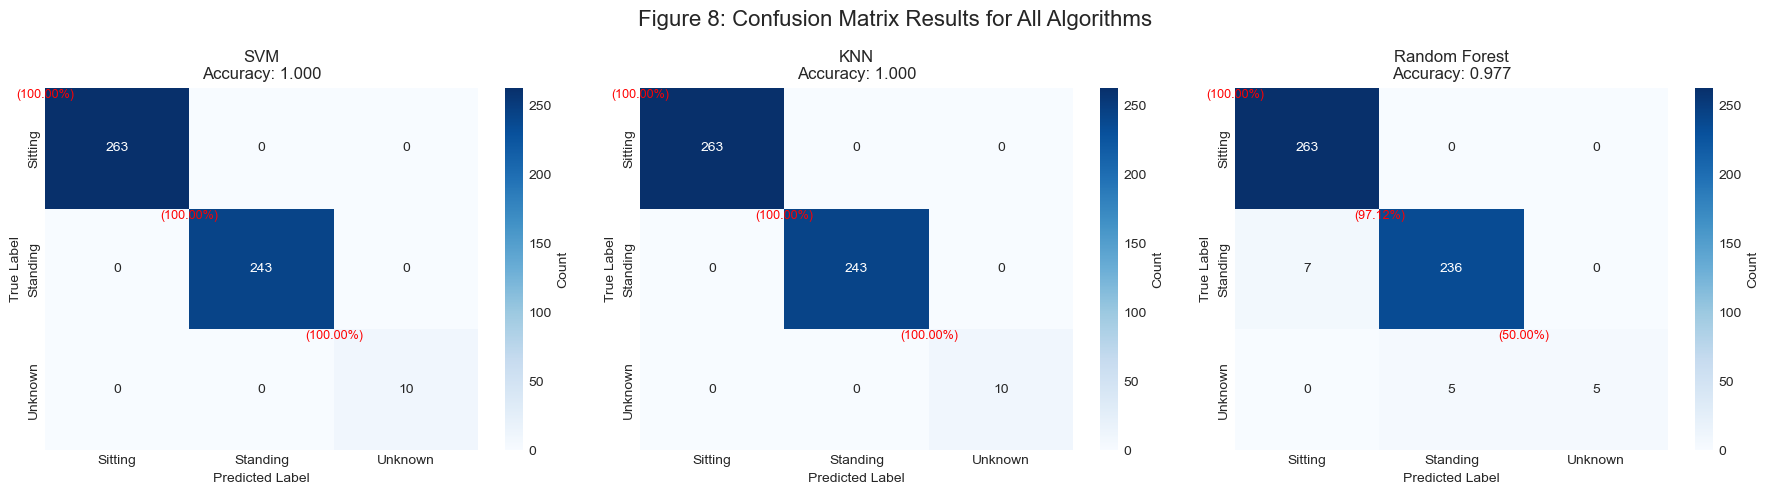


Detailed Classification Report for SVM:
              precision    recall  f1-score   support

     Sitting     1.0000    1.0000    1.0000       263
    Standing     1.0000    1.0000    1.0000       243
     Unknown     1.0000    1.0000    1.0000        10

    accuracy                         1.0000       516
   macro avg     1.0000    1.0000    1.0000       516
weighted avg     1.0000    1.0000    1.0000       516


Per-Class Performance Metrics:
Sitting:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  Support: 263

Standing:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  Support: 243

Unknown:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  Support: 10



In [ ]:
# confusion matrices for all models
print("Generating confusion matrices...")

# Confusion Matrix Results for All Algorithms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Figure 8: Confusion Matrix Results for All Algorithms', fontsize=16)

for idx, (model_name, ax) in enumerate(zip(models.keys(), axes)):
    cm = results[model_name]['confusion_matrix']
    
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    ax.set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]:.3f}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # Add accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracies):
        ax.text(i, i, f'\n({acc:.2%})', ha='center', va='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_8_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"\nDetailed Classification Report for {best_model_name}:")
print("="*60)
print(classification_report(y_test, 
                          label_encoder.inverse_transform(results[best_model_name]['predictions']),
                          target_names=class_names,
                          digits=4))


print("\nPer-Class Performance Metrics:")
print("="*60)
for i, class_name in enumerate(class_names):
    cm = results[best_model_name]['confusion_matrix']
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Support: {cm[i, :].sum()}")
    print()

Creating cross-validation performance visualization...


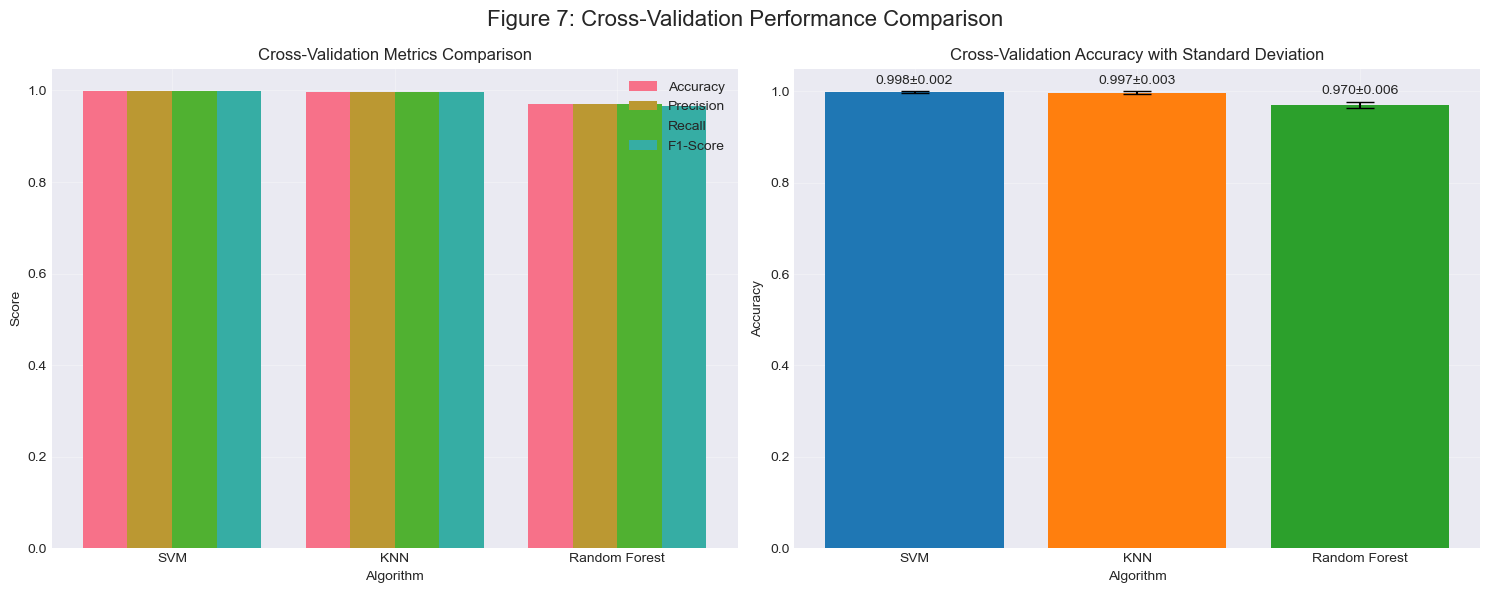

✓ Figure 7 saved successfully


In [ ]:
# Cross-Validation Performance Comparison
print("Creating cross-validation performance visualization...")

# Prepare data for visualization
cv_data = []
for model_name in models.keys():
    cv_data.append({
        'Algorithm': model_name,
        'Accuracy': cv_results[model_name]['val_accuracy'],
        'Precision': cv_results[model_name]['val_precision'],
        'Recall': cv_results[model_name]['val_recall'],
        'F1-Score': cv_results[model_name]['val_f1'],
        'Std': cv_results[model_name]['val_accuracy_std']
    })

cv_df = pd.DataFrame(cv_data)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Figure 7: Cross-Validation Performance Comparison', fontsize=16)

# Bar plot 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    values = cv_df[metric].values
    ax1.bar(x + i*width, values, width, label=metric)

ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Score')
ax1.set_title('Cross-Validation Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(cv_df['Algorithm'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error bar plot 
ax2.bar(x, cv_df['Accuracy'], yerr=cv_df['Std'], capsize=10, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Accuracy')
ax2.set_title('Cross-Validation Accuracy with Standard Deviation')
ax2.set_xticks(x)
ax2.set_xticklabels(cv_df['Algorithm'])
ax2.grid(True, alpha=0.3)

# Add value labels
for i, (acc, std) in enumerate(zip(cv_df['Accuracy'], cv_df['Std'])):
    ax2.text(i, acc + std + 0.01, f'{acc:.3f}±{std:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_7_cv_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 7 saved successfully")

Analyzing feature importance for Random Forest...


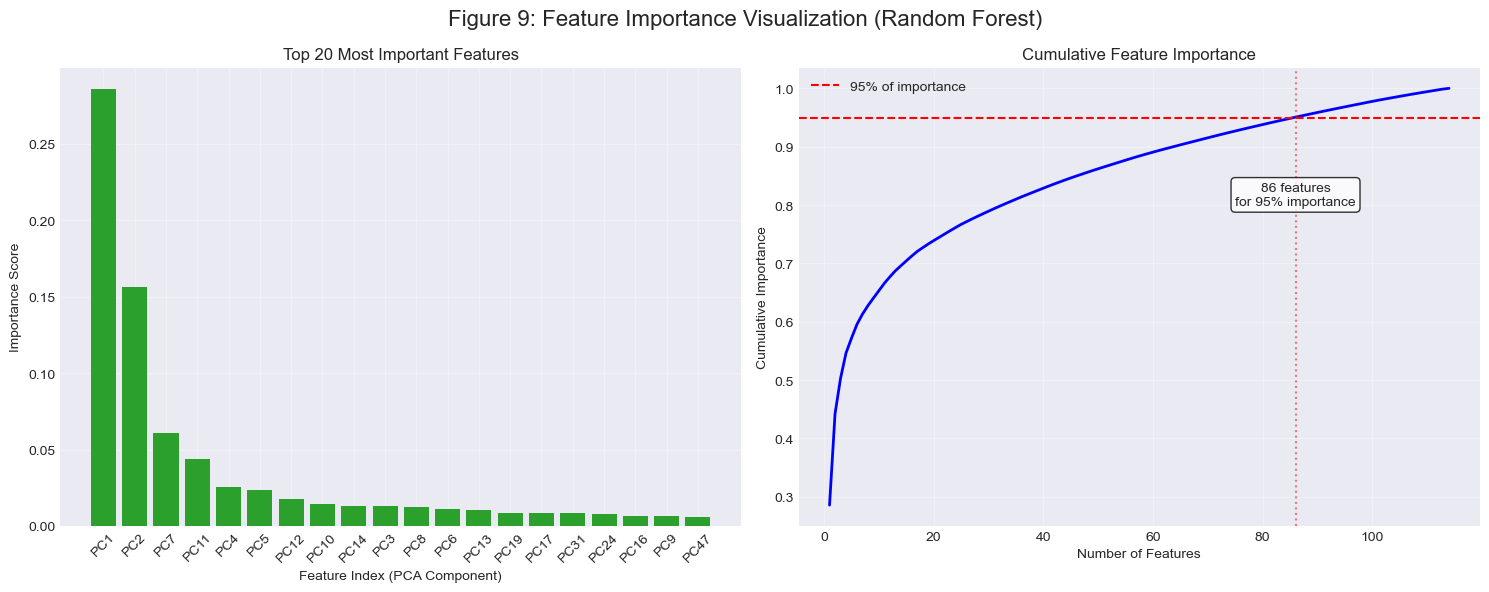


Feature Importance Summary:
- Total features: 114
- Features needed for 95% importance: 86
- Top 5 most important features:
  PC1: 0.2856
  PC2: 0.1564
  PC7: 0.0606
  PC11: 0.0435
  PC4: 0.0255

✓ Feature importances saved to: ../../results/models/feature_importances.csv


In [ ]:
# Feature importance analysis for Random Forest
print("Analyzing feature importance for Random Forest...")

#feature importances from Random Forest
rf_model = best_models['Random Forest']
feature_importances = rf_model.feature_importances_

# features by importance
indices = np.argsort(feature_importances)[::-1]
top_n = 20  # Show top 20 features

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Figure 9: Feature Importance Visualization (Random Forest)', fontsize=16)

# Bar plot of top features
ax1.bar(range(top_n), feature_importances[indices[:top_n]], color='#2ca02c')
ax1.set_xlabel('Feature Index (PCA Component)')
ax1.set_ylabel('Importance Score')
ax1.set_title(f'Top {top_n} Most Important Features')
ax1.set_xticks(range(top_n))
ax1.set_xticklabels([f'PC{indices[i]+1}' for i in range(top_n)], rotation=45)
ax1.grid(True, alpha=0.3)

# Cumulative importance plot
cumulative_importance = np.cumsum(feature_importances[indices])
ax2.plot(range(1, len(cumulative_importance)+1), cumulative_importance, 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% of importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# features with 95% importance
n_features_95 = np.argmax(cumulative_importance >= 0.95) + 1
ax2.axvline(x=n_features_95, color='r', linestyle=':', alpha=0.5)
ax2.text(n_features_95, 0.8, f'{n_features_95} features\nfor 95% importance', 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_9_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature Importance Summary:")
print(f"- Total features: {len(feature_importances)}")
print(f"- Features needed for 95% importance: {n_features_95}")
print(f"- Top 5 most important features:")
for i in range(5):
    print(f"  PC{indices[i]+1}: {feature_importances[indices[i]]:.4f}")


feature_importance_df = pd.DataFrame({
    'PCA_Component': [f'PC{i+1}' for i in range(len(feature_importances))],
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

feature_importance_df.to_csv(MODELS_PATH / 'feature_importances.csv', index=False)
print(f"\n✓ Feature importances saved to: {MODELS_PATH / 'feature_importances.csv'}")

In [ ]:
#  computational performance for edge deployment
print("Analyzing computational performance for edge deployment...")

# Measure inference time for each model
n_samples = 100  
test_samples = X_test[:n_samples]

inference_times = {}
model_sizes = {}

for model_name, model in best_models.items():
    
    start_time = time.time()
    for _ in range(10):  
        _ = model.predict(test_samples)
    inference_time = (time.time() - start_time) / 10  # Average time
    inference_times[model_name] = {
        'total_time': inference_time,
        'per_sample': inference_time / n_samples * 1000,  
        'fps': n_samples / inference_time
    }
    
    
    model_path = MODELS_PATH / f'{model_name.lower().replace(" ", "_")}_model.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    model_sizes[model_name] = os.path.getsize(model_path) / 1024 / 1024  # in MB


comp_perf_data = []
for model_name in models.keys():
    comp_perf_data.append({
        'Algorithm': model_name,
        'Training Time (s)': f"{cv_results[model_name]['training_time']:.2f}",
        'Inference Time (ms)': f"{inference_times[model_name]['per_sample']:.2f}",
        'Throughput (FPS)': f"{inference_times[model_name]['fps']:.1f}",
        'Model Size (MB)': f"{model_sizes[model_name]:.2f}",
        'Memory Usage': 'Low' if model_name == 'KNN' else 'Medium',
        'Suitable for Real-time': 'Yes' if inference_times[model_name]['fps'] > 30 else 'No'
    })

comp_perf_df = pd.DataFrame(comp_perf_data)
print("\nComputational Performance Analysis:")
print("="*80)
print(comp_perf_df.to_string(index=False))

# Save computational performance results
comp_perf_df.to_csv(MODELS_PATH / 'computational_performance.csv', index=False)
print(f"\n✓ Computational performance saved to: {MODELS_PATH / 'computational_performance.csv'}")


print("\n" + "="*80)
print("Edge Deployment:")
print("="*80)

for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"  ✓ Inference speed: {inference_times[model_name]['fps']:.1f} FPS")
    print(f"  ✓ Latency: {inference_times[model_name]['per_sample']:.2f} ms per prediction")
    print(f"  ✓ Model size: {model_sizes[model_name]:.2f} MB")
    
    if inference_times[model_name]['fps'] > 50:
        print(f"  → Excellent for real-time edge deployment")
    elif inference_times[model_name]['fps'] > 30:
        print(f"  → Suitable for real-time edge deployment")
    else:
        print(f"  → May require optimization for real-time use")


best_edge_model = max(models.keys(), 
                     key=lambda x: results[x]['accuracy'] * (1 + inference_times[x]['fps']/100))
print(f"\n✓ Recommended model for edge deployment: {best_edge_model}")
print(f"  (Balanced accuracy and speed)")

Analyzing computational performance for edge deployment...

Computational Performance Analysis:
    Algorithm Training Time (s) Inference Time (ms) Throughput (FPS) Model Size (MB) Memory Usage Suitable for Real-time
          SVM              5.07                0.02          59410.2            0.31       Medium                    Yes
          KNN              0.48                0.01          71209.4            1.81          Low                    Yes
Random Forest             41.68                0.03          29521.3            2.93       Medium                    Yes

✓ Computational performance saved to: ../../results/models/computational_performance.csv

Edge Deployment Recommendations:

SVM:
  ✓ Inference speed: 59410.2 FPS
  ✓ Latency: 0.02 ms per prediction
  ✓ Model size: 0.31 MB
  → Excellent for real-time edge deployment

KNN:
  ✓ Inference speed: 71209.4 FPS
  ✓ Latency: 0.01 ms per prediction
  ✓ Model size: 1.81 MB
  → Excellent for real-time edge deployment

Random Fo

In [ ]:
#  models and summary report
print("Saving trained models and creating summary report...")


for model_name, model in best_models.items():
    model_filename = f"{model_name.lower().replace(' ', '_')}_final.pkl"
    model_path = MODELS_PATH / model_filename
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved {model_name} to {model_filename}")

# Save label encoder
with open(MODELS_PATH / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Saved label encoder")


summary_report = f"""
PHYSIOTHERAPY POSITION CLASSIFICATION - MODEL TRAINING SUMMARY
=============================================================

Dataset Information:
- Total samples: {len(X_train) + len(X_test)}
- Training samples: {len(X_train)}
- Test samples: {len(X_test)}
- Number of classes: {len(class_names)}
- Classes: {', '.join(class_names)}
- Features: {X_train.shape[1]} PCA components (95% variance retained)

Model Performance Summary:
-------------------------
Best Model: {best_model_name}
Test Accuracy: {results[best_model_name]['accuracy']:.4f}
Cohen's Kappa: {results[best_model_name]['cohen_kappa']:.4f}

Detailed Results:
"""


for model_name in models.keys():
    summary_report += f"""
{model_name}:
- Best Parameters: {cv_results[model_name]['best_params']}
- CV Accuracy: {cv_results[model_name]['val_accuracy']:.4f} ± {cv_results[model_name]['val_accuracy_std']:.4f}
- Test Accuracy: {results[model_name]['accuracy']:.4f}
- Precision: {results[model_name]['precision']:.4f}
- Recall: {results[model_name]['recall']:.4f}
- F1-Score: {results[model_name]['f1']:.4f}
- Cohen's Kappa: {results[model_name]['cohen_kappa']:.4f}
- Training Time: {cv_results[model_name]['training_time']:.2f}s
- Inference Speed: {inference_times[model_name]['fps']:.1f} FPS
"""

summary_report += f"""
Edge Deployment Recommendation:
------------------------------
Recommended Model: {best_edge_model}
Reason: Best balance of accuracy and inference speed

Files Generated:
- model_comparison_results.csv
- computational_performance.csv
- feature_importances.csv
- figure_7_cv_performance_comparison.png
- figure_8_confusion_matrices.png
- figure_9_feature_importance.png
- Trained model files (.pkl)
"""

# Save summary report
with open(MODELS_PATH / 'training_summary.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print(f"\n✓ Summary report saved to: {MODELS_PATH / 'training_summary.txt'}")
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)

Saving trained models and creating summary report...
✓ Saved SVM to svm_final.pkl
✓ Saved KNN to knn_final.pkl
✓ Saved Random Forest to random_forest_final.pkl
✓ Saved label encoder

PHYSIOTHERAPY POSITION CLASSIFICATION - MODEL TRAINING SUMMARY

Dataset Information:
- Total samples: 2577
- Training samples: 2061
- Test samples: 516
- Number of classes: 3
- Classes: Sitting, Standing, Unknown
- Features: 114 PCA components (95% variance retained)

Model Performance Summary:
-------------------------
Best Model: SVM
Test Accuracy: 1.0000
Cohen's Kappa: 1.0000

Detailed Results:

SVM:
- Best Parameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
- CV Accuracy: 0.9981 ± 0.0018
- Test Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1-Score: 1.0000
- Cohen's Kappa: 1.0000
- Training Time: 5.07s
- Inference Speed: 59410.2 FPS

KNN:
- Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
- CV Accuracy: 0.9971 ± 0.0028
- Test Accuracy: